**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



In [17]:
'''
Dependencies
'''
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import metrics as met
from sklearn.model_selection import train_test_split as TTSplit
from sklearn.metrics import classification_report as ClassRep
from sklearn.metrics import confusion_matrix as ConfMat
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing, svm, ensemble



'''
Data Import from Files
'''
# Reading the train and test files
XTrainData = pd.read_csv("train_data.csv", header = None).values
YTrainData = pd.read_csv("train_labels.csv", header = None).values
XTestData = pd.read_csv("test_data.csv", header = None).values



'''
Data Normalization
'''
#Initialization of Scalers/Transformers/Normalizers
standard_scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
normalize = preprocessing.Normalizer()
quantile_transformer = preprocessing.QuantileTransformer(random_state = 0)

# Normalize the data with standard
#XTrainData = standard_scaler.fit_transform(XTrainData)
#TestData = standard_scaler.fit_transform(XTestData)

# Normalize the data with minmax
#XTrainData = min_max_scaler.fit_transform(XTrainData)
#TestData = min_max_scaler.fit_transform(XTestData)

# Normalize the data with robust scaler
XTrainData = robust_scaler.fit_transform(XTrainData)
XTestData = robust_scaler.fit_transform(XTestData)

# Normalize the data with Normalize
#XTrainData = normalize.fit_transform(XTrainData)
#XTestData = normalize.fit_transform(XTestData)

# Scale data onto Uniform Distribution [0, 1]
#XTrainData = quantile_transformer.fit_transform(XTrainData)
#XTestData = quantile_transformer.fit_transform(XTestData)




'''
Data Splits (Test and Train Sets)
'''
# Splitting the Test Data into Training and Testing Sets (both Features and Labels) 
XTrainSet, XTestSet, YTrainSet, YTestSet = TTSplit(XTrainData, YTrainData, test_size = 0.7)
Test_LabelSet_Size = len(YTestSet)
Train_LabelSet_Size = len(YTrainSet)

# Reshaping and preparing the training and testing sets. (R put with variable name (R = Refined)) 
# (Just re-shaped for now. To be refined later)
YTestR = np.reshape(YTestSet, (Test_LabelSet_Size, 1))
YTrainR = np.reshape(YTrainSet, (Train_LabelSet_Size, 1))



''' 
Multinomial Logistic Regression on the data
    Iterations = 5000
    Inverse Regularization Constant = 0.1 till 10
    Solver = SAGA
    Penalty = L1
'''
'''
C = 0.1
testAcc = []
validAcc = []
C_array = []


while C < 10:
    print('Inverse of Regularization Constant (C):', C)
    logreg = LogReg(penalty = 'l1', C = C, max_iter = 5000, solver ='saga', multi_class = 'multinomial')

    # Fitting the refined training sets 
    logreg.fit(XTrainSet, YTrainR.ravel())

    # Calculation of training accuracy
    predictTest = logreg.predict(XTestSet)
    predictTrain = logreg.predict(XTrainSet)

    # Display the calculated accuracies
    print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
    print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
    testAcc.append(met.accuracy_score(predictTrain, YTrainR))
    validAcc.append(met.accuracy_score(predictTest, YTestR))
    C_array.append(C)
    
    # Display final score from Logistic Regression
    
    score = logreg.score(XTestSet, YTestSet)
    print('Final Score: ', score, '\n')
    
    # Increase constant until > 10
    C = C * 1.2
'''





''' 
Gradient Boosting Classifier on the data
    Default Settings
'''
'''
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(XTrainSet, YTrainR.ravel())
predictTest = gbc.predict(XTestSet)
predictTrain = gbc.predict(XTrainSet)
score = gbc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''



''' 
Random Forest Classifier on the data
    Default Settings
'''
'''
rfc = ensemble.RandomForestClassifier()
rfc.fit(XTrainSet, YTrainR.ravel())
predictTest = rfc.predict(XTestSet)
predictTrain = rfc.predict(XTrainSet)
score = rfc.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')
'''





''' 
RBF SVM Classifier on the data
    Default Settings
'''

rbfsvm = svm.SVC()
rbfsvm.fit(XTrainSet, YTrainR.ravel())
predictTest = rbfsvm.predict(XTestSet)
predictTrain = rbfsvm.predict(XTrainSet)
score = rbfsvm.score(XTestSet, YTestSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainR))
print('Testing Accuracy: ', met.accuracy_score(predictTest, YTestR))
print('Final Score: ', score, '\n')



Inverse of Regularization Constant (C): 0.1


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5137614678899083
Testing Accuracy:  0.5050736497545009
Final Score:  0.5050736497545009 

Inverse of Regularization Constant (C): 0.12


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.514525993883792
Testing Accuracy:  0.5073649754500819
Final Score:  0.5073649754500819 

Inverse of Regularization Constant (C): 0.144


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.514525993883792
Testing Accuracy:  0.5076923076923077
Final Score:  0.5076923076923077 

Inverse of Regularization Constant (C): 0.17279999999999998


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5168195718654435
Testing Accuracy:  0.5080196399345336
Final Score:  0.5080196399345336 

Inverse of Regularization Constant (C): 0.20735999999999996


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5168195718654435
Testing Accuracy:  0.5090016366612111
Final Score:  0.5090016366612111 

Inverse of Regularization Constant (C): 0.24883199999999994


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.518348623853211
Testing Accuracy:  0.5086743044189853
Final Score:  0.5086743044189853 

Inverse of Regularization Constant (C): 0.29859839999999993


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.518348623853211
Testing Accuracy:  0.5086743044189853
Final Score:  0.5086743044189853 

Inverse of Regularization Constant (C): 0.3583180799999999


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5191131498470948
Testing Accuracy:  0.5096563011456628
Final Score:  0.5096563011456628 

Inverse of Regularization Constant (C): 0.4299816959999999


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5191131498470948
Testing Accuracy:  0.509328968903437
Final Score:  0.509328968903437 

Inverse of Regularization Constant (C): 0.5159780351999999


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5191131498470948
Testing Accuracy:  0.5096563011456628
Final Score:  0.5096563011456628 

Inverse of Regularization Constant (C): 0.6191736422399998


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5191131498470948
Testing Accuracy:  0.5099836333878887
Final Score:  0.5099836333878887 

Inverse of Regularization Constant (C): 0.7430083706879997


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5198776758409785
Testing Accuracy:  0.5099836333878887
Final Score:  0.5099836333878887 

Inverse of Regularization Constant (C): 0.8916100448255997


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5191131498470948
Testing Accuracy:  0.5099836333878887
Final Score:  0.5099836333878887 

Inverse of Regularization Constant (C): 1.0699320537907195


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5206422018348624
Testing Accuracy:  0.5103109656301146
Final Score:  0.5103109656301146 

Inverse of Regularization Constant (C): 1.2839184645488635


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5214067278287462
Testing Accuracy:  0.5103109656301146
Final Score:  0.5103109656301146 

Inverse of Regularization Constant (C): 1.5407021574586361


c:\python36\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy:  0.5214067278287462
Testing Accuracy:  0.5103109656301146
Final Score:  0.5103109656301146 

Inverse of Regularization Constant (C): 1.8488425889503632


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(C_array,testAcc)
plt.plot(C_array,validAcc)
plt.xscale('log')
plt.show()

In [ ]:
logreg = LogReg(C = 1.85, max_iter = 7500, solver ='sag', multi_class = 'multinomial', n_jobs = -2)
logreg.fit(XTrainSet, YTrainSet.ravel())
predictTrain = logreg.predict(XTrainSet)
print('Training Accuracy: ', met.accuracy_score(predictTrain, YTrainSet))


In [ ]:
writer = pd.ExcelWriter('logreg.xlsx', engine = 'xlsxwriter')
pd.DataFrame(logreg.predict(XTestData)).to_excel(writer, sheet_name = 'accuracy')
pd.DataFrame(logreg.predict_proba(XTestData)).to_excel(writer, sheet_name = 'logloss')
writer.save()

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

k_array = []
acc = []
for k in range(50):
    neigh = KNeighborsClassifier(n_neighbors=k+1, n_jobs = -2)
    neigh.fit(XTrainSet, YTrainSet.ravel())
    predLabels = neigh.predict(XTestSet)
    conf = confusion_matrix(YTestSet, predLabels)
    accuracy = np.trace(conf)/np.sum(conf)
    k_array.append(k+1)
    acc.append(accuracy)
    print('Accuracy:', accuracy,'with', k+1, 'neighbors')

Accuracy: 0.41898527004909986 with 1 neighbors
Accuracy: 0.492962356792144 with 2 neighbors
Accuracy: 0.5014729950900164 with 3 neighbors
Accuracy: 0.5155482815057283 with 4 neighbors
Accuracy: 0.5132569558101473 with 5 neighbors
Accuracy: 0.5227495908346972 with 6 neighbors
Accuracy: 0.5253682487725041 with 7 neighbors
Accuracy: 0.534860883797054 with 8 neighbors
Accuracy: 0.5404255319148936 with 9 neighbors
Accuracy: 0.5472995090016367 with 10 neighbors
Accuracy: 0.5515548281505729 with 11 neighbors
Accuracy: 0.5518821603927987 with 12 neighbors
Accuracy: 0.5515548281505729 with 13 neighbors
Accuracy: 0.5574468085106383 with 14 neighbors
Accuracy: 0.5561374795417349 with 15 neighbors
Accuracy: 0.5571194762684124 with 16 neighbors
Accuracy: 0.5610474631751228 with 17 neighbors
Accuracy: 0.5607201309328969 with 18 neighbors
Accuracy: 0.5613747954173486 with 19 neighbors
Accuracy: 0.5623567921440262 with 20 neighbors
Accuracy: 0.5643207855973813 with 21 neighbors
Accuracy: 0.56464811783

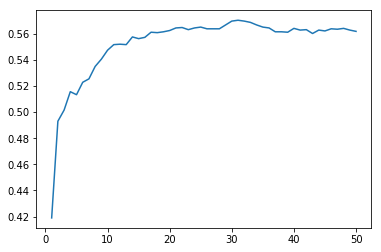

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(k_array,acc)
plt.show()

In [14]:
neigh = KNeighborsClassifier(n_neighbors=20, n_jobs = -2)
neigh.fit(XTrainSet, YTrainSet)
predLabels = neigh.predict(XTestSet)
conf = confusion_matrix(YTestSet, predLabels)
accuracy = np.trace(conf)/np.sum(conf)
print('Accuracy:', accuracy)
logloss = neigh.predict_proba(XTestSet)

c:\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy: 0.5623567921440262


In [16]:
writer = pd.ExcelWriter('kneigh.xlsx', engine = 'xlsxwriter')
pd.DataFrame(neigh.predict(XTestData)).to_excel(writer, sheet_name = 'accuracy')
pd.DataFrame(neigh.predict_proba(XTestData)).to_excel(writer, sheet_name = 'logloss')
writer.save()

In [ ]:
#UNTESTED
def logLoss(probabilities):
    probabilities = probabilities / np.sum(probabilities, axis = 1) #normalize sums of probabilities to 1
    classes = np.argmax(probabilities, axis = 1)
    logsum = 0
    for i in range(probabilities.shape[0]):
        logsum += np.log(probabilities[i,classes[i]])
    return logsum/probabilities.shape[0]

In [3]:
# Load the data and cleanup

In [4]:
#Analysis of the input data
# ...

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [5]:
# Trials with ML algorithms

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [6]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *